In [18]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import itertools
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [19]:
# Spaces for in- and output
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
Z = tp.spaces.R1('z')
U = tp.spaces.R3('u')

# Parameter
fskal =18333
kappa = 18333.3/fskal # GPa = 18333,33 Mpa
mu = 3928.57/fskal # GPa = 3928.57 Mpa
u_dis = 0.2 # mm
size = 5.0  # mm

In [20]:
# Load stl.file and create domain
Ix = tp.domains.Interval(X, -size, size)
Iy = tp.domains.Interval(Y, -size, size)
Iz = tp.domains.Interval(Z, -size, size)
cube = Ix * Iy * Iz

In [21]:
# network to train
model = tp.models.Sequential(
    tp.models.NormalizationLayer(cube),
    tp.models.FCN(input_space=X*Y*Z, output_space=U, hidden=(30,30,30,30,30)))

In [22]:
inner_sampler = tp.samplers.RandomUniformSampler(cube, n_points = 12*12*12) #.make_static()
#top_sampler = tp.samplers.RandomUniformSampler(Ix*Iy*Iz.boundary_right, n_points=1000)
#bottom_sampler = tp.samplers.RandomUniformSampler(Ix*Iy*Iz.boundary_left, n_points=1000)
#y_side_sampler = tp.samplers.RandomUniformSampler(Ix*Iy.boundary*Iz, n_points=2000)
#x_side_sampler = tp.samplers.RandomUniformSampler(Ix.boundary*Iy*Iz, n_points=2000)

#fig = tp.utils.scatter(X*Y*Z, inner_sampler)
#fig.get_axes()[0].view_init(30, 170)
#fig.set_size_inches(10, 8)

In [23]:
# apply boundary condition via hard constrains:
def constrain_fn(u, x, y, z):
    u_con = torch.zeros_like(u)
    # x direction:
    u_con[:, :1] = u[:, :1] * (x - size) * (x + size) * (z + size) /1000
    # y direction:
    u_con[:, 1:2] = u[:, 1:2] * (y - size) * (y + size) * (z + size) /1000
    # z direction:
    press = - u_dis * torch.cos(math.pi/10.0 * x) * torch.cos(math.pi/10.0 * y)
    u_con[:, 2:] = u[:, 2:] * (z - size) * (z + size) /10 + (z + size)/10.0 * press
    return u_con

In [24]:
# Compute C:
def delta(a, b):
    return a == b

C = torch.zeros((3, 3, 3, 3), dtype=torch.float32)
for i,j,k,l in itertools.product(range(3), range(3), range(3), range(3)):
    unit_prod = delta(i, j) * delta(k, l)
    P_sym = 0.5 * (delta(i, k) * delta(j, l) + delta(j, k) * delta(i, l)) - 1/3.0*unit_prod
    C[i,j,k,l] = kappa * unit_prod + 2*mu*P_sym

# reshape to (9, 1, 3, 3), to apply to batch of the form ("1", batch_dim, 3, 3)
C = C.reshape(9, 1, 3, 3)
if torch.cuda.device_count() > 0:
    C = C.to('cuda')

In [25]:
## test C stuff:
#a = torch.tensor([[[1.0, 0.0, 2.0], [1.0, 1.0, 2.0], [0.0, 1.0, 2.0]], 
#                  [[1.0, 1.0, 2.0], [1.0, 5.0, 2.0], [5.0, 1.0, 2.0]]])
#b = C*a
#print(b.sum(dim=(2, 3)).T.reshape(len(a), 3, 3))

In [26]:
# inner pde condition:
def pde_residual(u, C, x, y, z):
    u_con = constrain_fn(u, x, y, z)
    sym_grad = tp.utils.sym_grad(u_con, x, y, z)
    prod = C*sym_grad
    sigma = (prod.sum(dim=(2, 3))).T.reshape(len(u), 3, 3)
    return tp.utils.matrix_div(sigma, x, y, z) # + forces


pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            data_functions={'C': C}, weight=100)

In [27]:
# Training 
optim = tp.solver.OptimizerSetting(torch.optim.Adam, lr=0.075) 
solver = tp.solver.Solver([pde_condition],optimizer_setting = optim)

trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=4000,
                     logger=False,
                     checkpoint_callback=False
                     )
trainer.fit(solver)

C:\Users\inu2sh\.conda\envs\TorchPhysics\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 3.9 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.016     Total estimated model params size (MB)
C:\Users\inu2sh\.conda\envs\TorchPhysics\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bo

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'Verschiebung in x-Richtung [mm]')

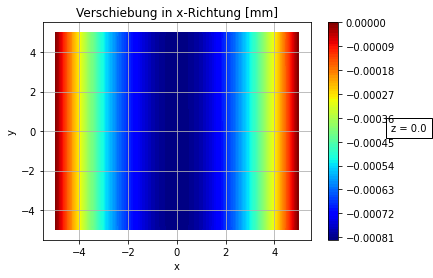

In [28]:
from matplotlib import pyplot
def plot_fn(u, x, y, z):
    u_con = constrain_fn(u, x, y, z)
    return u_con[:, 0]

xy_square = tp.domains.Parallelogram(X*Y, [-size, -size], [size, -size], [-size, size])
samp = tp.samplers.PlotSampler(xy_square, n_points=1000, data_for_other_variables={'z': 0.0})
fig = tp.utils.plot(model, plot_fn, samp, plot_type='contour_surface')
pyplot.title('Verschiebung in x-Richtung [mm]')
#pyplot.savefig('Verschiebung-x-Richtung.png', dvi=360)

C:\Users\inu2sh\AppData\Local\Temp\ipykernel_4536\1059405203.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error in 3.6
  pyplot.savefig('Verschiebung-x-Richtung-Linie.png', dvi=360)


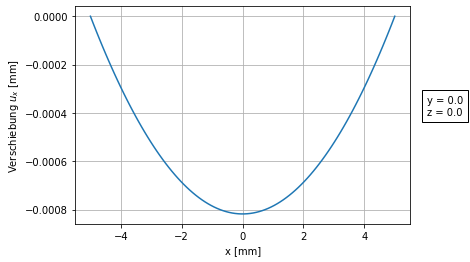

In [29]:
x_interval = tp.domains.Interval(X, -size, size)
samp1 = tp.samplers.PlotSampler(x_interval, n_points=100, data_for_other_variables={'y':0,'z': 0.0})
fig = tp.utils.plot(model, plot_fn, samp1)
pyplot.ylabel('Verschiebung $u_x$ [mm]')
pyplot.xlabel('x [mm]')
pyplot.savefig('Verschiebung-x-Richtung-Linie.png', dvi=360)

C:\Users\inu2sh\AppData\Local\Temp\ipykernel_4536\792788879.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error in 3.6
  pyplot.savefig('Verschiebung-z-Richtung.png', dvi=360)


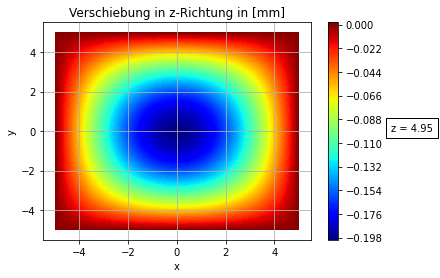

In [30]:
from matplotlib import pyplot
def plot_fn(u, x, y, z):
    u_con = constrain_fn(u, x, y, z)
    return u_con[:, 2]

xy_square = tp.domains.Parallelogram(X*Y, [-size, -size], [size, -size], [-size, size])
samp = tp.samplers.PlotSampler(xy_square, n_points=1000, data_for_other_variables={'z': 4.95})
fig = tp.utils.plot(model, plot_fn, samp, plot_type='contour_surface')
pyplot.title('Verschiebung in z-Richtung in [mm]')
pyplot.savefig('Verschiebung-z-Richtung.png', dvi=360)

In [31]:
# Training mit statischem Sampling
inner_sampler = tp.samplers.RandomUniformSampler(cube, n_points = 32*32*32).make_static()
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.2, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

pde_condition.sampler = pde_condition.sampler.make_static()

solver = tp.solver.Solver([pde_condition], optimizer_setting=optim)

trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=3000,
                     logger=False,
                     checkpoint_callback=False
                     )
trainer.fit(solver)

C:\Users\inu2sh\.conda\envs\TorchPhysics\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 3.9 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.016     Total estimated model params size (MB)
C:\Users\inu2sh\.conda\envs\TorchPhysics\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bo

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\inu2sh\AppData\Local\Temp\ipykernel_4536\2433404883.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error in 3.6
  pyplot.savefig('Verschiebung-y-Richtung.png', dvi=360)


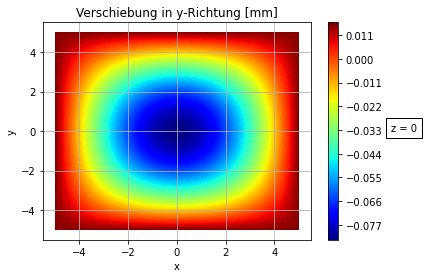

In [32]:
def plot_fn(u, x, y, z):
    u_con = constrain_fn(u, x, y, z)
    return u_con[:, 2]

xy_square = tp.domains.Parallelogram(X*Y, [-size, -size], [size, -size], [-size, size])
samp = tp.samplers.PlotSampler(xy_square, n_points=1000, data_for_other_variables={'z': 0})
fig = tp.utils.plot(model, plot_fn, samp, plot_type='contour_surface')
pyplot.title('Verschiebung in y-Richtung [mm]')
pyplot.savefig('Verschiebung-y-Richtung.png', dvi=360)

C:\Users\inu2sh\AppData\Local\Temp\ipykernel_4536\4102769041.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error in 3.6
  pyplot.savefig('sigma-x-y-z=45.png', dvi=360)


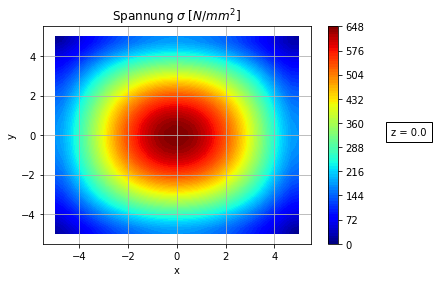

In [33]:
kappa = 18333.3
mu = 3928.57 

C = torch.zeros((3, 3, 3, 3), dtype=torch.float32)
for i,j,k,l in itertools.product(range(3), range(3), range(3), range(3)):
    unit_prod = delta(i, j) * delta(k, l)
    P_sym = 0.5 * (delta(i, k) * delta(j, l) + delta(j, k) * delta(i, l)) - 1/3.0*unit_prod
    C[i,j,k,l] = kappa * unit_prod + 2*mu*P_sym
    
C = C.reshape(9, 1, 3, 3)

def strain_fn(u, x, y, z):
    u_con = constrain_fn(u, x, y, z)
    sym_grad = tp.utils.sym_grad(u_con, x, y, z)
    prod = C*sym_grad
    sigma = (prod.sum(dim=(2, 3))).T.reshape(len(u), 3, 3)
    return torch.norm(sigma, dim=(1,2))
samp = tp.samplers.PlotSampler(xy_square, n_points=1000, data_for_other_variables={'z':0.0})
fig = tp.utils.plot(model, strain_fn, samp, plot_type='contour_surface')
pyplot.title('Spannung $\sigma$ $[N/mm^2]$')
pyplot.savefig('sigma-x-y-z=45.png', dvi=360)

Text(0, 0.5, 'Spannung $N/mm^2$')

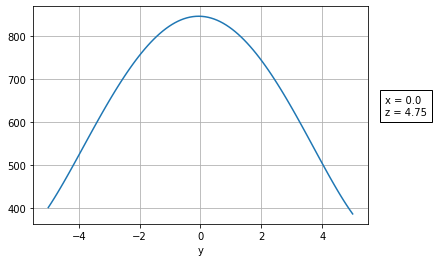

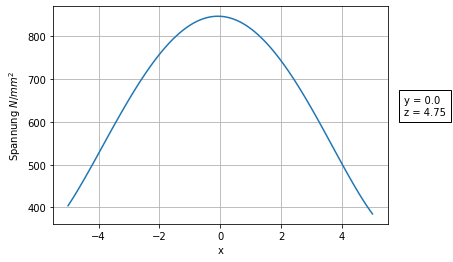

In [34]:
x_interval = tp.domains.Interval(X, -size, size)
y_interval = tp.domains.Interval(Y, -size, size)
z_ebene = 4.75
samp1 = tp.samplers.PlotSampler(y_interval, n_points=100, data_for_other_variables={'x':0.0,'z': z_ebene})
samp2 = tp.samplers.PlotSampler(x_interval, n_points=100, data_for_other_variables={'y':0.0,'z': z_ebene})
fig1 = tp.utils.plot(model, strain_fn, samp1)
fig2 = tp.utils.plot(model, strain_fn, samp2)
pyplot.ylabel('Spannung $N/mm^2$')

    #´ß0431    ´ß098765430